In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime

#import gspread as gs

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
mer=pd.read_excel(r'C:\Users\bantenuc\OneDrive - Ternium\Escritorio\BRUNO\Tesis\MERVAL.xlsx', sheet_name=0) #sheet_name=0 brings first sheet, =1 brings 2nd sheet
mer = mer.dropna() #is it ok to drop NaN values
mer = mer.reset_index()
mer = mer.drop('index', axis=1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#df=df.set_index('Date')
mer

,Date,PX,Vol,FX,FXr
0,2003-08-20,231.236,19192120.000,0.998,0.000
1,2003-08-21,236.742,13316130.000,0.999,0.001
2,2003-08-22,230.066,8887194.000,0.999,0.000
3,2003-08-25,235.315,7764827.000,1.000,0.001
4,2003-08-26,238.695,6482494.000,1.000,0.000
...,...,...,...,...,...
4742,2022-12-27,1110.704,13719264.000,174.829,0.001
4743,2022-12-28,1148.398,14561103.000,175.752,0.005
4744,2022-12-29,1127.745,12139953.000,176.065,0.002
4745,2022-12-30,1140.866,8946027.000,176.390,0.002


In [ ]:
#Describe the info of the df (count, mean, std, min, max, etc)
mer.describe().transpose()

In [ ]:
mer['Date'] = pd.to_datetime(mer.Date) #convert the date string into date object
#df.Date.dt.day_name() -> brings the name of the dayweek
mer.dtypes

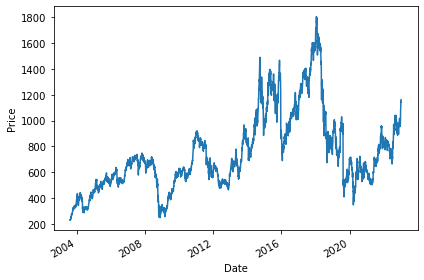

In [3]:
fig, ax = plt.subplots()

ax.plot(mer.Date,mer['PX'])
ax.set_xlabel('Date')
ax.set_ylabel('Price')


fig.autofmt_xdate()
plt.tight_layout()

In [6]:
mer["PXret"] = mer.PX.pct_change(1).mul(100)
mer["PXvolat"] = mer.PXret.abs()
mer['PXdiff'] = mer.PX.diff()
mer=mer.set_index(mer.Date)
mer

,Date,PX,Vol,FX,FXr,PXret,PXvolat,PXdiff
Date,,,,,,,,
2003-08-20,2003-08-20,231.236,19192120.000,0.998,0.000,NaN,NaN,NaN
2003-08-21,2003-08-21,236.742,13316130.000,0.999,0.001,2.381,2.381,5.506
2003-08-22,2003-08-22,230.066,8887194.000,0.999,0.000,-2.820,2.820,-6.676
2003-08-25,2003-08-25,235.315,7764827.000,1.000,0.001,2.282,2.282,5.250
2003-08-26,2003-08-26,238.695,6482494.000,1.000,0.000,1.436,1.436,3.380
...,...,...,...,...,...,...,...,...
2022-12-27,2022-12-27,1110.704,13719264.000,174.829,0.001,1.416,1.416,15.511
2022-12-28,2022-12-28,1148.398,14561103.000,175.752,0.005,3.394,3.394,37.694
2022-12-29,2022-12-29,1127.745,12139953.000,176.065,0.002,-1.798,1.798,-20.653


In [ ]:
# Stationarity check for PX
ADF_result = adfuller(mer.PX[1:])
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

In [ ]:
# Stationarity check for PXret
ADF_result = adfuller(mer.PXret[1:])
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

In [ ]:
# Stationarity check for PXvolat
ADF_result = adfuller(mer.PXvolat[1:])
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

In [ ]:
# Stationarity check for PXvolat
ADF_result = adfuller(mer.PXdiff[1:])
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

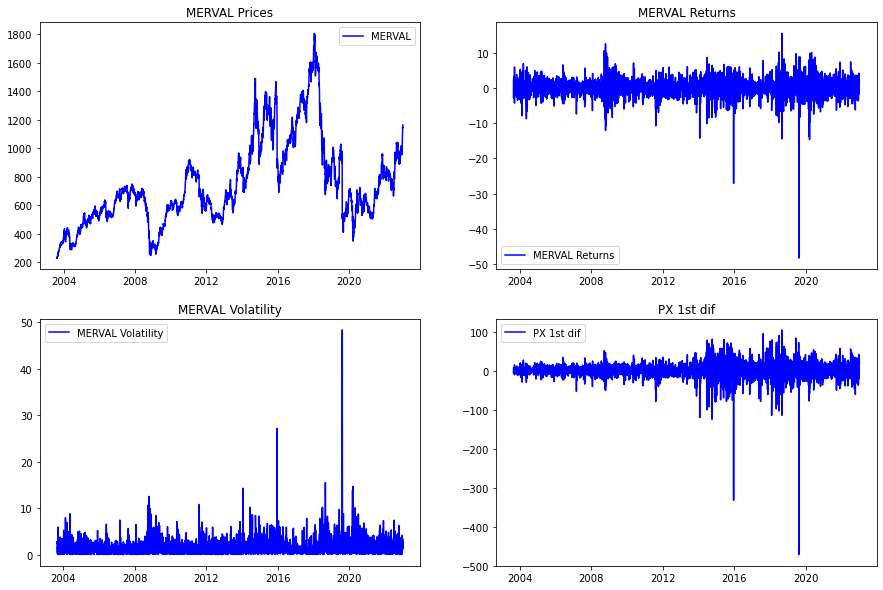

In [5]:
plt.rcParams["figure.figsize"] = (15, 10)

#fig, ax = plt.subplots(1, 4)
fig, ax = plt.subplots(2, 2)


ax[0,0].plot(mer.PX, color = "blue", label = "MERVAL")
ax[0,0].set_title("MERVAL Prices", size = 12)
ax[0,0].legend()

ax[0,1].plot(mer.PXret, color = "blue", label = "MERVAL Returns")
ax[0,1].set_title("MERVAL Returns", size = 12)
ax[0,1].legend()

ax[1,0].plot(mer.PXvolat, color = "blue", label = "MERVAL Volatility")
ax[1,0].set_title("MERVAL Volatility", size = 12)
ax[1,0].legend()

ax[1,1].plot(mer.PXdiff, color = "blue", label = "PX 1st dif")
ax[1,1].set_title("PX 1st dif", size = 12)
ax[1,1].legend()



plt.show()

In [7]:
#Split into train and test
train = mer[:int(0.9*len(mer))]
test = mer[int(0.9*len(mer)):]


In [ ]:
#Plot a variable for every year 
plt.rcParams["figure.figsize"] = 18, 5

for year in set(train.index.year):
    plt.plot(train[["PX"]].loc[train.index.year == year])
    plt.title(str(year), size = 24)
    plt.show()

In [10]:
train["Year"] = train.index.year

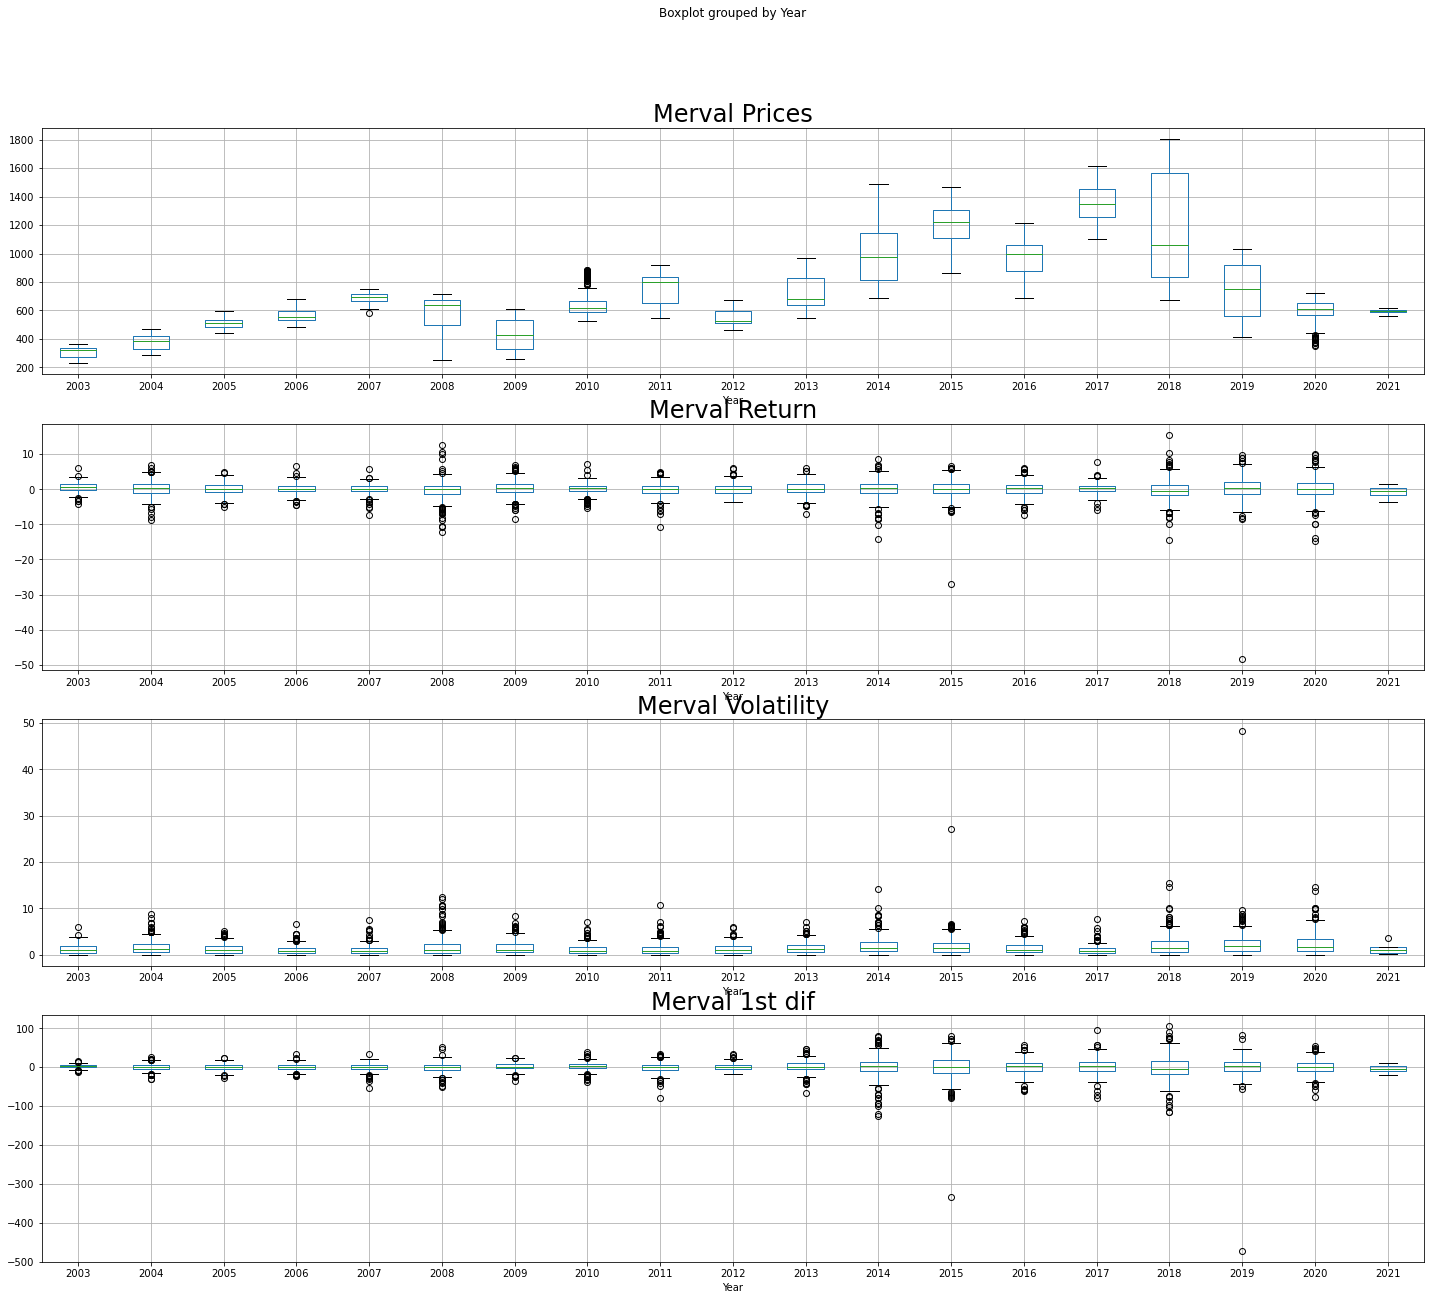

In [11]:
plt.rcParams["figure.figsize"] = 24, 21

fig, axes = plt.subplots(4, 1)

train.boxplot(by ='Year', column =['PX'], ax = axes[0])
axes[0].set_title("Merval Prices", size = 24)

train.boxplot(by ='Year', column =['PXret'], ax = axes[1])
axes[1].set_title("Merval Return", size = 24)

train.boxplot(by ='Year', column =['PXvolat'], ax = axes[2])
axes[2].set_title("Merval Volatility", size = 24)

train.boxplot(by ='Year', column =['PXdiff'], ax = axes[3])
axes[3].set_title("Merval 1st dif", size = 24)

plt.show()

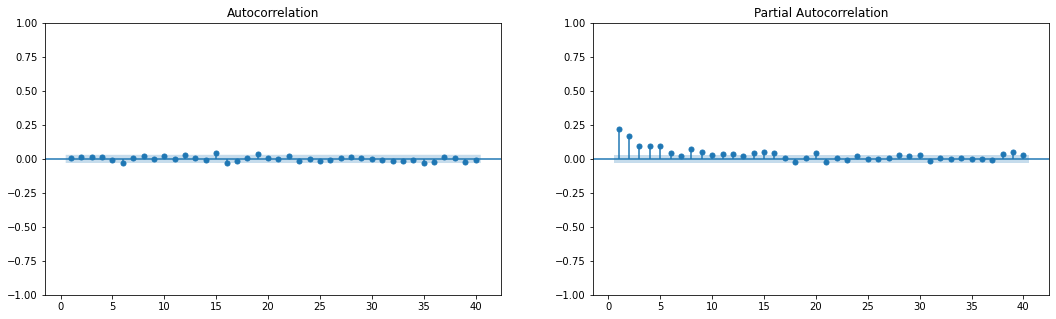

In [13]:
import statsmodels.graphics.tsaplots as sgt
plt.rcParams["figure.figsize"] = 18, 5
fig, axes = plt.subplots(1, 2)
sgt.plot_acf(train.PXret[1:], zero = False, lags = 40, ax = axes[0])
sgt.plot_pacf(train.PXvolat[1:], zero = False, lags = 40, ax = axes[1])
plt.show() #First two lags on volatility are significant

In [18]:
mer

,Date,PX,Vol,FX,FXr,PXret,PXvolat,PXdiff
Date,,,,,,,,
2003-08-20,2003-08-20,231.236,19192120.000,0.998,0.000,NaN,NaN,NaN
2003-08-21,2003-08-21,236.742,13316130.000,0.999,0.001,2.381,2.381,5.506
2003-08-22,2003-08-22,230.066,8887194.000,0.999,0.000,-2.820,2.820,-6.676
2003-08-25,2003-08-25,235.315,7764827.000,1.000,0.001,2.282,2.282,5.250
2003-08-26,2003-08-26,238.695,6482494.000,1.000,0.000,1.436,1.436,3.380
...,...,...,...,...,...,...,...,...
2022-12-27,2022-12-27,1110.704,13719264.000,174.829,0.001,1.416,1.416,15.511
2022-12-28,2022-12-28,1148.398,14561103.000,175.752,0.005,3.394,3.394,37.694
2022-12-29,2022-12-29,1127.745,12139953.000,176.065,0.002,-1.798,1.798,-20.653


In [41]:
garch_df = pd.DataFrame(mer["PXret"].loc[mer.index])
#garch_df.at[train.index, "PXret"] = train["PXret"]

In [33]:
!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org pip arch

In [36]:
from arch import arch_model

In [42]:
model = arch_model(garch_df["PXret"][1:], p = 2, q = 2, vol = "GARCH")
model_results = model.fit(last_obs = test.index[0], update_freq = 5)

Iteration:      5,   Func. Count:     44,   Neg. LLF: 9361.599722738398
Iteration:     10,   Func. Count:     83,   Neg. LLF: 9195.592041309308
Iteration:     15,   Func. Count:    118,   Neg. LLF: 9195.524591567053
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9195.524591567053
            Iterations: 16
            Function evaluations: 124
            Gradient evaluations: 16


In [38]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  PXret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9195.52
Distribution:                  Normal   AIC:                           18403.0
Method:            Maximum Likelihood   BIC:                           18441.2
                                        No. Observations:                 4271
Date:                Sat, Jan 07 2023   Df Residuals:                     4270
Time:                        13:35:49   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1363  3.286e-02      4.147  3.361e-05 [7.189e-02,  0.201]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3326      0.490      0.679      0.497   [ -0.628,  1.293]
alpha[1]       0.2429  9.185e-02      2.644  8.193e-03 [6.283e-02,  0.423]
alpha[2]       0.0000      0.330      0.000      1.000   [ -0.647,  0.647]
beta[1]        0.5267      1.234      0.427      0.670   [ -1.892,  2.946]
beta[2]        0.1990      0.860      0.232      0.817   [ -1.486,  1.884]
==========================================================================

Covariance estimator: robust
"""

In [44]:
#model prediction GARCH

predictions = test.copy()
predictions["Predictions"] = model_results.forecast().residual_variance.loc[test.index]

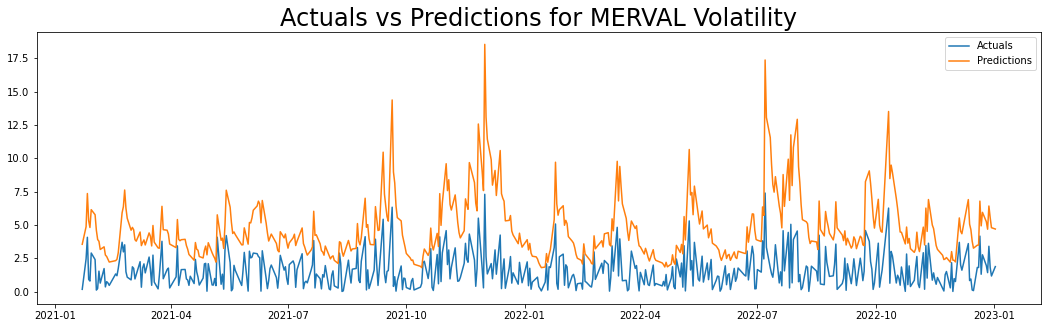

In [63]:
# Ploting predictions 

plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions["PXvolat"], label = "Actuals")
plt.plot(predictions["Predictions"], label = "Predictions")

plt.title("Actuals vs Predictions for MERVAL Volatility", size = 24)

plt.legend()
plt.show()

In [47]:
np.sqrt(mean_squared_error(predictions["PXret"].abs(), predictions["Predictions"]))

3.6185955968302395